In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/frenchenglish-translation/fra.tsv


#### Importing data

In [2]:
data = pd.read_csv('/kaggle/input/frenchenglish-translation/fra.tsv', delimiter='\t')
data.head()

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


#### Since the dataset has around 1,50,000 training examples but we will be using only 60,000 rows to keep it simple.

In [3]:
data = data.iloc[:50000, :]

english = data.english.values
french = data.french.values

#### Exploring dataset

In [4]:
print("Length of english sentence ", len(english))
print("Length of french sentence ", len(french))
print('-'*20)
print(english[100])
print('-'*20)
print(french[100])

Length of english sentence  50000
Length of french sentence  50000
--------------------
Come in.
--------------------
Entre !


#### Remove all punctuations from text

In [5]:
english = [s.translate(str.maketrans('', '', string.punctuation)) for s in english]
french = [s.translate(str.maketrans('', '', string.punctuation)) for s in french]

print(english[100])
print('-'*20)
print(french[100])

Come in
--------------------
Entre 


#### Convert all examples to lowercase

In [6]:
english = [s.lower() if isinstance(s, str) else s for s in english]
french = [s.lower() if isinstance(s, str) else s for s in french]

print(english[100])
print('-'*20)
print(french[100])

come in
--------------------
entre 


#### Visualise the length of examples

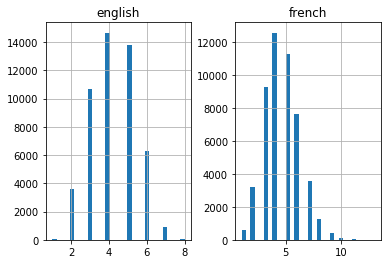

In [7]:
eng_l = [len(s.split()) for s in english]
fre_l = [len(s.split()) for s in french]

length_df = pd.DataFrame({'english': eng_l, 'french': fre_l})
length_df.hist(bins=30)
plt.show()

In [8]:
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, RepeatVector, Dropout, Bidirectional, Flatten

Using TensorFlow backend.


In [9]:
def tokenizer(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

english_tokenizer = tokenizer(english)
french_tokenizer = tokenizer(french)

word_index_english = english_tokenizer.word_index
word_index_french = french_tokenizer.word_index

eng_vocab_size = len(word_index_english) + 1
fre_vocab_size = len(word_index_french) + 1

In [10]:
print("Size of english vocab:", len(word_index_english))
print("Size of french vocab:", len(word_index_french))

Size of english vocab: 6490
Size of french vocab: 14827


In [11]:
max_len_eng = max(eng_l)
max_len_fre = max(fre_l)

print("Max length of english sentence:", max_len_eng)
print("Max length of french sentence:", max_len_fre)

Max length of english sentence: 8
Max length of french sentence: 13


In [12]:
english = pd.Series(english).to_frame('english')
french = pd.Series(french).to_frame('french')

dummy_df = pd.concat([english, french], axis=1)
train, test = train_test_split(dummy_df, test_size=0.1, random_state=42)

train_english = train.english.values
train_french = train.french.values

test_english = test.english.values
test_french = test.french.values

In [13]:
def encode_sequences(tokenizer, length, text):
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=length, padding='post')
    return sequences

In [14]:
eng_seq = encode_sequences(english_tokenizer, max_len_eng, train_english)
fre_seq = encode_sequences(french_tokenizer, max_len_fre, train_french)

# test_english = encode_sequences(english_tokenizer, max_len_eng, test_english)
test_french = encode_sequences(french_tokenizer, max_len_fre, test_french)

print(eng_seq[10])
print(fre_seq[10])

[  6 482 389   0   0   0   0   0]
[  24  422 8908    0    0    0    0    0    0    0    0    0    0]


In [15]:
def nmt_model(in_vocab_size, out_vocab_size, in_timestep, out_timestep, units):
    model = Sequential()
    model.add(Embedding(in_vocab_size, units, input_length=in_timestep, mask_zero=True))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4)))
    model.add(Dropout(0.5))
    model.add(RepeatVector(out_timestep))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Dense(out_vocab_size, activation="softmax"))
    return model

In [16]:
model = nmt_model(fre_vocab_size, eng_vocab_size, max_len_fre, max_len_eng, 256)

In [17]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=rms, metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 256)           3795968   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 13, 512)           1050624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 512)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 13, 512)           1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 512)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

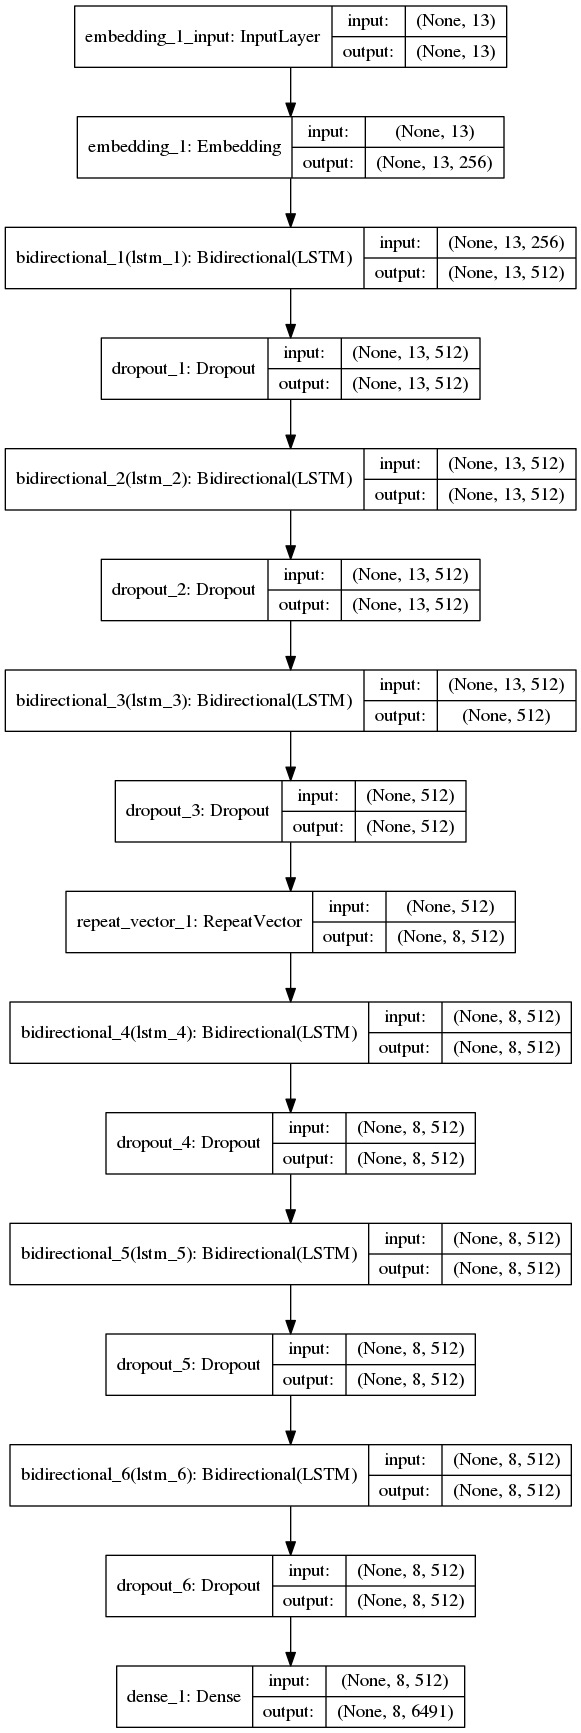

In [19]:
plot_model(model, show_shapes=True)

In [20]:
eng_seq = eng_seq.reshape(eng_seq.shape[0], eng_seq.shape[1], 1)
history = model.fit(fre_seq, eng_seq, batch_size=256, epochs=400, verbose=1, validation_split=0.07, shuffle=True)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 41850 samples, validate on 3150 samples
Epoch 1/400
41850/41850 [==============================] - 47s 1ms/step - loss: 3.5617 - accuracy: 0.4978 - val_loss: 3.2216 - val_accuracy: 0.5134
Epoch 2/400
41850/41850 [==============================] - 35s 829us/step - loss: 3.1878 - accuracy: 0.5170 - val_loss: 3.0674 - val_accuracy: 0.5287
Epoch 3/400
41850/41850 [==============================] - 36s 860us/step - loss: 3.0530 - accuracy: 0.5275 - val_loss: 2.9834 - val_accuracy: 0.5342
Epoch 4/400
41850/41850 [==============================] - 35s 835us/step - loss: 2.9680 - accuracy: 0.5355 - val_loss: 2.9001 - val_accuracy: 0.5435
Epoch 5/400
41850/41850 [==============================] - 36s 849us/step - loss: 2.8805 - accuracy: 0.5448 - val_loss: 2.7741 - val_accuracy: 0.5600
Epoch 6/400
41850/41850 [==============================] - 35s 843us/step - loss: 2.7939 - accuracy: 0.5564 - val_loss: 2.6755 - val_accuracy: 0.5725
Epoch 7/400
41850/41850 [============================

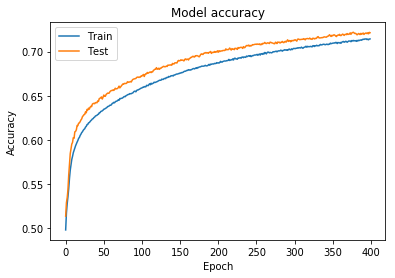

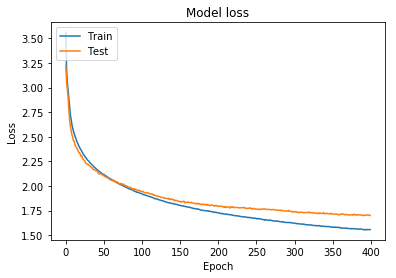

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
prediction = model.predict_classes(test_french.reshape(test_french.shape[0], test_french.shape[1]))

In [23]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [24]:
preds_text = []
for i in prediction:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], english_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], english_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(' '.join(temp))

In [25]:
pred_df = pd.DataFrame({'actual' : test_english, 'predicted' : preds_text})

In [26]:
pred_df.head(7)

,actual,predicted
0,talk to me if you want,tell me what you want
1,wheres my son,wheres your father
2,take it,run up
3,tom seems happy,tom seems happy
4,it takes one to know one,have yourself
5,youre very good at this,youre very good of that
6,i made that one,i did that one


In [27]:
pred_df.tail(7)

,actual,predicted
4993,waiter i need a spoon,a i need a
4994,whats new,whats it
4995,no antidote is available,no is
4996,whats your major,whats your you
4997,no one else spoke,no one agreed with me
4998,we have a decision to make,we need to make a decision
4999,im seldom at home,i almost at home
